# **Install Libraries** **- Llama 3.1 - 8B Instruct - (QA)**

In [1]:
!pip install transformers accelerate bitsandbytes datasets
#!pip install -q -U evaluate
!pip install -q -U tokenizers
!pip install nltk
!pip install transformers torch accelerate
!pip install git+https://github.com/huggingface/trl.git@main


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.9/72.9 MB 31.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 119.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 98.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 61.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 44.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 99.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

## Import Packages

In [2]:

%env PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True

import torch
import pandas as pd
import os
from datasets import Dataset, DatasetDict
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    BitsAndBytesConfig,
    TrainingArguments,
    set_seed
)
from peft import get_peft_model, LoraConfig, TaskType,prepare_model_for_kbit_training
from trl import SFTTrainer

from transformers import LlamaTokenizer, LlamaForCausalLM, Trainer
from datasets import load_dataset



env: PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True


In [3]:
!pip install -q transformers huggingface_hub

# Login (you'll be prompted to paste your token)
!huggingface-cli login

⚠️  Warning: 'huggingface-cli login' is deprecated. Use 'hf auth login' instead.

    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) Y
Token is valid (permission: read).
The token `colab_token` has been saved to /root/.cache/huggingface/stored_tokens
Cannot authenticate through git-credenti

# Data Preparation

In [4]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [5]:

# Folder where all CSV files are located
folder_path = "/content/drive/My Drive/Colab Notebooks/DS-266/Data/qa-data"

import re

# Get all CSV files in the folder
csv_files = [f for f in os.listdir(folder_path) if f.endswith(".csv")]

# Read and combine all CSVs
qa_combined_df = pd.concat([pd.read_csv(os.path.join(folder_path, f)) for f in csv_files])

# Function to remove contents within << >>
def remove_double_angle_brackets(text):
    return re.sub(r"<<.*?>>", "", text)

# Apply to a specific column (e.g., 'answer')
qa_combined_df["answer"] = qa_combined_df["answer"].apply(remove_double_angle_brackets)

qa_combined_df = qa_combined_df.dropna(subset=["question", "answer"])



In [ ]:
qa_combined_df.describe()

,question,answer
count,8792,8792
unique,8792,8792
top,Henry and 3 of his friends order 7 pizzas for ...,There are 7*8=56 slices in total.\nThere are 1...
freq,1,1


In [ ]:
qa_combined_df['question'].value_counts().head()


,count
question,
"Henry and 3 of his friends order 7 pizzas for lunch. Each pizza is cut into 8 slices. If Henry and his friends want to share the pizzas equally, how many slices can each of them have?",1
"Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How many clips did Natalia sell altogether in April and May?",1
"Weng earns $12 an hour for babysitting. Yesterday, she just did 50 minutes of babysitting. How much did she earn?",1
"Betty is saving money for a new wallet which costs $100. Betty has only half of the money she needs. Her parents decided to give her $15 for that purpose, and her grandparents twice as much as her parents. How much more money does Betty need to buy the wallet?",1
"Julie is reading a 120-page book. Yesterday, she was able to read 12 pages and today, she read twice as many pages as yesterday. If she wants to read half of the remaining pages tomorrow, how many pages should she read?",1


In [ ]:
duplicate_questions = qa_combined_df['question'][qa_combined_df['question'].duplicated()].unique()
duplicate_questions


array([], dtype=object)

In [6]:
# Step 1: Sort by answer length (keep the longer one, assuming it's more complete)
qa_combined_df['answer_length'] = qa_combined_df['answer'].str.len()

# Step 2: Drop duplicates on 'question', keeping the row with the longest answer
qa_unique = qa_combined_df.sort_values('answer_length', ascending=True).drop_duplicates(subset='question', keep='first')

# Step 3: Drop the helper column
qa_unique = qa_unique.drop(columns=['answer_length'])

In [7]:
qa_unique.describe()

,question,answer
count,8792,8792
unique,8792,8792
top,Peggy is moving and is looking to get rid of h...,Sammy is offering to take the whole collection...
freq,1,1


In [8]:
qa_unique[:5]
#final numberic answer
# Does it get 84? wrong answer debug the pattern

,question,answer
4144,You have 32$ to spend on groceries. You buy a...,32-3=29\n29-2=27\n27(1/3)=9\n27-9=18$\n#### 18
5516,A cat has nine lives. A dog has 3 less lives ...,Dog:9-3=6 lives\nMouse:6+7=13 lives\n#### 13
3794,Kendra made 4 more than five times as many dec...,Kendra made 4+5*8=44.\nSue made 44/2=22.\n#### 22
4519,Mari made 4 more than five times as many decor...,Kendra made 2*6=12.\nMari made 4+5*12=64.\n###...
695,There are 50 deer in a field. 50 percent of t...,Bucks:50(.50)=25\n8 Points:25(.20)=5 bucks\n##...


In [9]:
import pandas as pd

# Function to split steps and final answer
def extract_steps_and_answer(solution):
    if pd.isna(solution):
        return pd.Series(["", ""])
    if '####' in solution:
        steps, final_answer = solution.split('####')
        return pd.Series([steps.strip(), final_answer.strip()])
    else:
        return pd.Series([solution.strip(), ""])

# Apply to DataFrame
qa_unique[['steps', 'final_answer']] = qa_unique['answer'].apply(extract_steps_and_answer)

qa_final = qa_unique[['question',  'final_answer']]

# Preview the result
print(qa_unique[['question', 'steps', 'final_answer']].head())


                                               question  \
4144  You have 32$ to spend on groceries.  You buy a...   
5516  A cat has nine lives.  A dog has 3 less lives ...   
3794  Kendra made 4 more than five times as many dec...   
4519  Mari made 4 more than five times as many decor...   
695   There are 50 deer in a field.  50 percent of t...   

                                           steps final_answer  
4144       32-3=29\n29-2=27\n27(1/3)=9\n27-9=18$           18  
5516         Dog:9-3=6 lives\nMouse:6+7=13 lives           13  
3794    Kendra made 4+5*8=44.\nSue made 44/2=22.           22  
4519   Kendra made 2*6=12.\nMari made 4+5*12=64.           64  
695   Bucks:50(.50)=25\n8 Points:25(.20)=5 bucks            5  


In [10]:
qa_final[:5]


,question,final_answer
4144,You have 32$ to spend on groceries. You buy a...,18
5516,A cat has nine lives. A dog has 3 less lives ...,13
3794,Kendra made 4 more than five times as many dec...,22
4519,Mari made 4 more than five times as many decor...,64
695,There are 50 deer in a field. 50 percent of t...,5


In [11]:
# Convert to Hugging Face dataset
dataset = Dataset.from_pandas(qa_final.drop(columns=["index"], errors="ignore").reset_index(drop=True))


In [12]:
dataset

Dataset({
    features: ['question', 'final_answer'],
    num_rows: 8792
})

## Split the Dataset


In [13]:
shuffled = dataset.shuffle(seed=42)


#Split before tokenizing
# Split the shuffled dataset
train_small = shuffled.select(range(0, 500))# First 500 samples
train_medium = shuffled.select(range(500, 3000))     # Next 1500 samples

train_large = shuffled.select(range(3000, 6000))     # Next 2,000 samples
validation_set = shuffled.select(range(7000, 7050))
test_set = shuffled.select(range(8000, 8792))


# Model - Llama-3.1


In [ ]:
# Model Download and save to the Drive
# model_name = "meta-llama/Meta-Llama-3.1-8B-Instruct" # finetuned model
# save_path = "/content/drive/My Drive/Colab Notebooks/DS-266/llama3_1_8b"  #  directory in Colab


# tokenizer = AutoTokenizer.from_pretrained(model_name, token=True)
# tokenizer.save_pretrained(save_path)


('/content/drive/My Drive/Colab Notebooks/DS-266/llama3_1_8b/tokenizer_config.json',
 '/content/drive/My Drive/Colab Notebooks/DS-266/llama3_1_8b/special_tokens_map.json',
 '/content/drive/My Drive/Colab Notebooks/DS-266/llama3_1_8b/chat_template.jinja',
 '/content/drive/My Drive/Colab Notebooks/DS-266/llama3_1_8b/tokenizer.json')

In [15]:
# Download the Saved Model
base_model = AutoModelForCausalLM.from_pretrained("/content/drive/My Drive/Colab Notebooks/DS-266/llama3_1_8b/saved_base_model/", device_map="auto")
tokenizer = AutoTokenizer.from_pretrained("/content/drive/My Drive/Colab Notebooks/DS-266/llama3_1_8b/saved_base_model/")

Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

In [16]:
tokenizer.pad_token = tokenizer.eos_token


In [17]:
# Tokenize the input
def tokenize_for_only_answer(example, tokenizer, max_total_length=214):
    question_text = example['question']
    final_answer_value = example['final_answer']

    # 1. Construct the full prompt text for this specific prompt
    full_prompt_text = (
        f"You are a math problem solver. Just output the final numerical answer.\n\n"
        f"Example:\nProblem: What is 5 + 3?\nAnswer: 8\n\n"
        f"Problem: {question_text}\nAnswer: "
    )

    # 2. Combine with the target final answer
    full_sequence_text = full_prompt_text + str(final_answer_value) + tokenizer.eos_token

    # 3. Tokenize the entire sequence
    tokenized_output = tokenizer(
        full_sequence_text,
        truncation=True,
        max_length=max_total_length,
        padding="max_length",
        return_tensors="pt"
    )

    input_ids = tokenized_output["input_ids"].squeeze(0)
    attention_mask = tokenized_output["attention_mask"].squeeze(0)

    # 4. Create labels: Mask the prompt part
    prompt_tokenized_for_length = tokenizer(
        full_prompt_text,
        truncation=True,
        max_length=max_total_length,
        padding=False,
        return_tensors="pt" # This returns [1, length]
    )["input_ids"]

    prompt_length_in_tokens = prompt_tokenized_for_length.shape[1] # Correctly gets length from [1, length]

    labels = input_ids.clone()
    labels[:prompt_length_in_tokens] = -100
    labels = labels.squeeze(0)

    return {
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "labels": labels
    }

In [18]:


# For training the minimal_steps_teacher model:
train_500= train_small.map(
    lambda x: tokenize_for_only_answer(x, tokenizer),
    remove_columns=['question',  'final_answer'] # Remove original text columns
)
train_1500 = train_medium.map(
    lambda x: tokenize_for_only_answer(x, tokenizer),
    remove_columns=['question',  'final_answer']
)


train_2000 = train_large.map(
    lambda x: tokenize_for_only_answer(x, tokenizer),
    remove_columns=['question',  'final_answer'])

valid = validation_set.map(
    lambda x: tokenize_for_only_answer(x, tokenizer),
    remove_columns=['question',  'final_answer']
)
test = test_set.map(
    lambda x: tokenize_for_only_answer(x, tokenizer),
    remove_columns=['question',  'final_answer']
)

print(f"Tokenized: {len(train_500)} train_500, {len(train_1500)} train_1500, {len(valid)} valid, {len(test)} test.")


Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/2500 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/792 [00:00<?, ? examples/s]

Tokenized: 500 train_500, 2500 train_1500, 50 valid, 792 test.


In [ ]:
# base_model = AutoModelForCausalLM.from_pretrained(
#     model_name,
#     device_map="auto"  # or "cpu" if you want to force CPU
# )


In [ ]:

# # # Save both to disk
# base_model.save_pretrained("/content/drive/My Drive/Colab Notebooks/DS-266/llama3_1_8b/saved_base_model")
# print("Base model saved successfully!")


Base model saved successfully!


In [ ]:
# tokenizer.save_pretrained("/content/drive/My Drive/Colab Notebooks/DS-266/llama3_1_8b/saved_base_model")
# print("Tokenizer saved successfully")

Tokenizer saved successfully


In [ ]:
# Load from saved base model:

base_model = AutoModelForCausalLM.from_pretrained("/content/drive/My Drive/Colab Notebooks/DS-266/llama3_1_8b/saved_base_model/", device_map="auto")
tokenizer = AutoTokenizer.from_pretrained("/content/drive/My Drive/Colab Notebooks/DS-266/llama3_1_8b/saved_base_model/")

Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

In [ ]:
# #Sanity check
# for item in test_data:
#     print(f"Q: {item['question']}\nExpected: {item['answer']}\n")
pad_token_id=tokenizer.eos_token_id,
eos_token_id=tokenizer.eos_token_id

In [19]:
import re

def extract_answer(output, prompt_type):
    """
    Extracts the first numeric value from the model's generated output based on prompt type.

    Parameters:
    - output (str): Model's generated text (after the prompt).
    - prompt_type (str): Type of prompt used (e.g., "few_shot_math_only_answer", "single_shot").

    Returns:
    - int or float if number found, else None
    """
    # Match any integer or float, including negative numbers
    number_pattern = r'(-?\d+(?:\.\d+)?)'

    if prompt_type in ["few_shot_math_only_answer", "single_shot"]:
        # Assume the model's answer starts with or contains the number
        numbers = re.findall(number_pattern, output)
        if numbers:
            val = numbers[0]
            try:
                return float(val) if '.' in val else int(val)
            except ValueError:
                return None
        return None

    # Fallback for unexpected prompt types
    print(f"Warning: Unknown prompt_type '{prompt_type}' in extract_answer. Returning None.")
    return None




In [20]:
from tqdm import tqdm

# Define your prompt templates
prompt_templates = {
    "single_shot": lambda q: f"{q}\nA: Please only give the final answer as a number.\nAnswer:",
    "few_shot_math_only_answer": lambda q: f"""
Here are examples of math problems and ONLY their final numerical answers:

Q: John has 5 apples, eats 2, then buys 4 more. How many apples does he have?
Answer: 7

Q: A square has sides of length 5. What is its area?
Answer: 25

Q: A car travels 100 miles in 2 hours. If it continues for another hour at the same speed, how many total miles will it have traveled?
Answer: 150

---
Now, provide ONLY the final numerical answer for the following question:

Q: {q}
Answer:"""
}

# Define shared config
shared_config = {
    "max_tokens": 15,
    "temperature": 0.3,
    "top_p": 0.9
}



def evaluate_model(prompt_name, prompt_config, dataset, model, tokenizer, max_samples=None):

    correct = 0
    records = []

    prompt_fn = prompt_config["prompt_fn"]
    max_tokens = prompt_config.get("max_tokens", 256)
    temperature = prompt_config.get("temperature", 0.7)
    top_p = prompt_config.get("top_p", 0.9)

    iterator = dataset if max_samples is None else dataset[:max_samples]

    for example in tqdm(iterator, desc=f"Evaluating {prompt_name}"):
        question = example["question"]
        expected_answer = example["final_answer"]

        prompt = prompt_fn(question)
        inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_new_tokens=max_tokens,
                pad_token_id=tokenizer.eos_token_id,
                temperature=temperature,
                top_p=top_p,
                do_sample=True,
                num_return_sequences=1
            )

        decoded_full = tokenizer.decode(outputs[0], skip_special_tokens=True)
        generated_text = decoded_full[len(prompt):].strip()

        pred = extract_answer(generated_text, prompt_name)

        is_correct = False
        if pred is not None:
            try:
                if abs(float(pred) - float(expected_answer)) < 1e-6:
                    is_correct = True
            except (ValueError, TypeError):
                pass

        if is_correct:
            correct += 1

        records.append({
            "question": question,
            "expected_answer": expected_answer,
            "predicted_answer": pred,
            "full_output": generated_text,
            "is_correct": is_correct,
            "prompt": prompt_name
        })

    accuracy = correct / len(iterator) if len(iterator) > 0 else 0
    results_df = pd.DataFrame(records)
    return accuracy, results_df


In [ ]:
acc_dict = {}
results_dict = {}

for prompt_name in ["single_shot", "few_shot_math_only_answer"]:
    prompt_config = {
        "prompt_fn": prompt_templates[prompt_name],
        "max_tokens": shared_config["max_tokens"],
        "temperature": shared_config["temperature"],
        "top_p": shared_config["top_p"]
    }

    print(f"\n{'='*10} Testing Prompt: {prompt_name} {'='*10}")
    accuracy, results_df = evaluate_model(prompt_name, prompt_config, test_set.select(range(300)), base_model, tokenizer)
    acc_dict[prompt_name] = accuracy * 100
    results_dict[prompt_name] = results_df
    print(f"Accuracy for '{prompt_name}': {accuracy * 100:.2f}%")
    print("=" * 50)



========== Testing Prompt: single_shot ==========


Evaluating single_shot: 100%|██████████| 300/300 [03:25<00:00,  1.46it/s]


Accuracy for 'single_shot': 13.33%

========== Testing Prompt: few_shot_math_only_answer ==========


Evaluating few_shot_math_only_answer: 100%|██████████| 300/300 [03:42<00:00,  1.35it/s]

Accuracy for 'few_shot_math_only_answer': 15.33%


# Error Analysis

In [ ]:
# save_result_dict to drive
wrong_df_single_shot = results_dict["single_shot"]

save_path = "/content/drive/My Drive/Colab Notebooks/DS-266/test_result_before_trianing_single_shot.csv"  #  directory in Colab

wrong_df_single_shot.to_csv(save_path, index=False)
wrong_df_single_shot[:3]

,question,expected_answer,predicted_answer,full_output,is_correct,prompt
0,The green piece of yarn is 156 cm long. The re...,632,1.0,Step 1: Determine the length of the green yarn...,False,single_shot
1,"For homework, Juan's teacher asked everyone in...",101,1.0,"Step 1: First, we need to calculate the total...",False,single_shot
2,Tim sleeps 6 hours per day for 5 days a week a...,50,6.0,Step-by-step reasoning process: 6 × 5 + 10 ×,False,single_shot


In [ ]:
wrong_df_few_shot = results_dict["few_shot_math_only_answer"]

save_path = "/content/drive/My Drive/Colab Notebooks/DS-266/test_result_before_trianing_few_shot.csv"  #  directory in Colab

wrong_df_few_shot.to_csv(save_path, index=False)
wrong_df_few_shot[:3]


,question,expected_answer,predicted_answer,full_output,is_correct,prompt
0,The green piece of yarn is 156 cm long. The re...,632,474.0,474\n\n---\n\nI will now provide the final num...,False,few_shot_math_only_answer
1,"For homework, Juan's teacher asked everyone in...",101,68.0,68\n\n---\n\nQ: A bakery sells 250 loaves of b...,False,few_shot_math_only_answer
2,Tim sleeps 6 hours per day for 5 days a week a...,50,NaN,_______ \n\n(No explanation or work shown) (J...,False,few_shot_math_only_answer


{'single_shot': 10.333333333333334, 'few_shot_math_only_answer': 14.333333333333334}


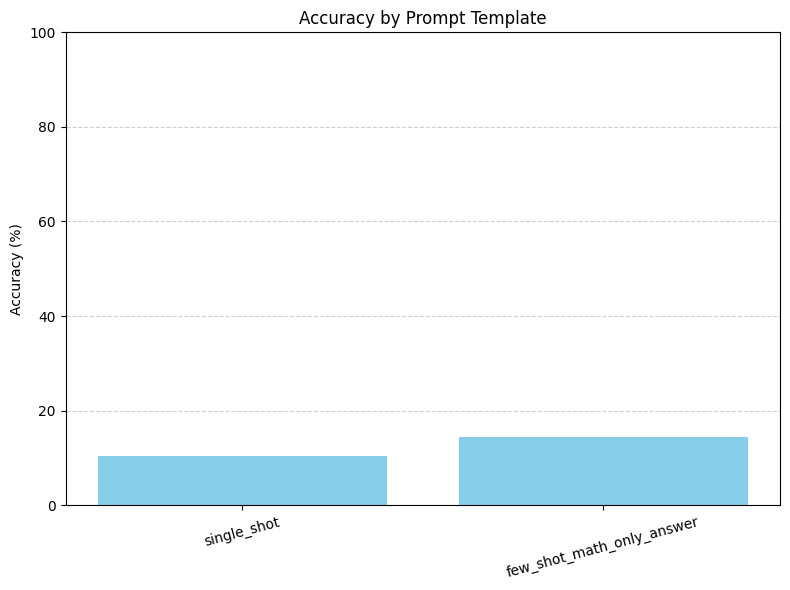

In [22]:
import matplotlib.pyplot as plt


# Extracting prompt names and accuracies
prompt_names = list(acc_dict.keys())
accuracies = list(acc_dict.values())

# Print dictionary for reference
print(acc_dict)

# Plot
plt.figure(figsize=(8, 6))
bars = plt.bar(prompt_names, accuracies, color='skyblue')


plt.ylabel("Accuracy (%)")
plt.title("Accuracy by Prompt Template")
plt.ylim(0, 100)
plt.xticks(rotation=15)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()



# Train Model

In [23]:
# train Model on 2k datasets
!pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=b5e62175108103a0de17abf6d4887934f463a606770920095968f83cc1f12c0f
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge_score


In [ ]:
from rouge_score import rouge_scorer

# def compute_rouge_scores(model, tokenizer, dataset, prompt_fn, max_new_tokens=30):
#     scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
#     scores = []

#     for example in tqdm(dataset, desc="ROUGE Eval"):
#         question = example['question'][0]
#         reference = example['answer'][0]  # Full answer

#         prompt = prompt_fn(question)
#         inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
#         output = model.generate(**inputs, max_new_tokens=max_new_tokens)
#         prediction = tokenizer.decode(output[0], skip_special_tokens=True)

#         # Optional: strip prompt from output if model echoes input
#         prediction_only = prediction.replace(prompt, "").strip()

#         score = scorer.score(reference, prediction_only)
#         scores.append(score['rougeL'].fmeasure)

#     avg_rouge_l = sum(scores) / len(scores) if scores else 0
#     return avg_rouge_l


In [25]:
import numpy as np

def extract_numerical_answer(text: str):
    # Try #### N, or "Answer: N", then fallback to last number
    m = re.search(r"(?:####\s*|Answer:\s*)(-?\d+(?:\.\d+)?)\s*$", text.strip())
    if m:
        return m.group(1)
    nums = re.findall(r"-?\d+(?:\.\d+)?", text)
    return nums[-1] if nums else None

def _to_list(x):
    return x.tolist() if isinstance(x, np.ndarray) else x

def _replace_ignore_idx(labels, pad_id):
    out = []
    for seq in labels:
        seq = list(seq)
        out.append([tok if tok != -100 else pad_id for tok in seq])
    return out

def compute_metrics(eval_pred):
    # Hugging Face may pass a tuple or an EvalPrediction
    if isinstance(eval_pred, tuple):
        predictions, labels = eval_pred
    else:
        predictions, labels = eval_pred.predictions, eval_pred.label_ids

    # If predictions are logits (batch, seq_len, vocab), convert to token ids
    if isinstance(predictions, np.ndarray) and predictions.ndim == 3:
        predictions = predictions.argmax(-1)

    # Convert to python lists for safer processing
    predictions = _to_list(predictions)
    labels      = _to_list(labels)

    # Replace -100 in labels for decoding
    pad_id = tokenizer.pad_token_id if tokenizer.pad_token_id is not None else tokenizer.eos_token_id
    labels = _replace_ignore_idx(labels, pad_id)

    # Decode
    decoded_preds  = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels,      skip_special_tokens=True)

    # ROUGE-L
    from rouge_score import rouge_scorer
    scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)

    rouge_l_scores = []
    correct_num = 0
    total_num   = 0

    for pred, ref in zip(decoded_preds, decoded_labels):
        pred = pred.strip()
        ref  = ref.strip()

        # ROUGE-L (guard empty)
        if not pred and not ref:
            rouge_l_scores.append(1.0)
        elif not pred or not ref:
            rouge_l_scores.append(0.0)
        else:
            rouge = scorer.score(ref, pred)
            rouge_l_scores.append(rouge['rougeL'].fmeasure)

        # numeric accuracy
        pnum = extract_numerical_answer(pred)
        rnum = extract_numerical_answer(ref)
        if pnum is not None and rnum is not None:
            total_num += 1
            try:
                if float(pnum) == float(rnum):
                    correct_num += 1
            except ValueError:
                pass

    rougeL = float(np.mean(rouge_l_scores)) if rouge_l_scores else 0.0
    num_acc = (100.0 * correct_num / total_num) if total_num > 0 else 0.0
    return {"rougeL": rougeL, "numerical_accuracy": num_acc}


In [26]:

import os
import gc
import torch

# Optional: Reduces memory fragmentation for large models
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

# Clear GPU memory
gc.collect()
torch.cuda.empty_cache()

# Model and quant config
model_name = "/content/drive/My Drive/Colab Notebooks/DS-266/llama3_1_8b/saved_base_model"
#model_name = "meta-llama/Meta-Llama-3.1-8B-Instruct"


bnb_config = BitsAndBytesConfig(

    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4"

)


base_model_4bit = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.bfloat16,
    quantization_config=bnb_config,
    device_map="auto",
    token = token,
    trust_remote_code=True

    # Let HF auto-dispatch across GPU and CPU

)


# Enable gradient checkpointing BEFORE LoRA or preparation
base_model_4bit.gradient_checkpointing_enable()
base_model_4bit.enable_input_require_grads()

# Monkey patch: prevent float32 cast in low RAM
def prepare_model_for_kbit_training_lowmem(model):
    for param in model.parameters():
        param.requires_grad = False
        # Avoid converting to float32 to prevent OOM
        if hasattr(param, "dtype") and param.__class__.__name__ != "Params4bit":
            continue
    model.gradient_checkpointing_enable()
    model.enable_input_require_grads()
    return model

# Use patched version to avoid OOM
base_model_4bit = prepare_model_for_kbit_training_lowmem(base_model_4bit)


Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

In [27]:
#LoRA (Low-Rank Adaptation)  - Fine tuning the LLM
#QLora - Prof feedback , CHange r and alpha
# Look fine tuning notebook with limited RAM
# Model -> test data - measure

lora_config = LoraConfig(
    r=4, # LoRA rank
    lora_alpha=16, # Scaling factor for the LoRA weights
    lora_dropout=0.0, #Dropout rate applied to LoRA layers during training
    bias="none",
    task_type="CAUSAL_LM", # CAUSAL_LM - for decoder only model
    target_modules=["q_proj", "v_proj"]
)


model = get_peft_model(base_model_4bit, lora_config)
model.print_trainable_parameters()


trainable params: 1,703,936 || all params: 8,031,965,184 || trainable%: 0.0212


In [28]:

training_args = TrainingArguments(
    output_dir="./llama3-qlora-out",
    optim="paged_adamw_8bit",
    max_grad_norm=0.3,
    per_device_train_batch_size=1,
    gradient_accumulation_steps=16,
    logging_steps=10,
    save_strategy="epoch",
    num_train_epochs=1,
    learning_rate=5e-5,
    bf16=True,
    gradient_checkpointing=True,
    report_to="none",
    eval_strategy="epoch"


)


In [29]:

import os
os.environ["WANDB_DISABLED"] = "true"          # disables everything
os.environ["WANDB_MODE"] = "disabled"          # no offline/online/anonymous


In [34]:

import torch, gc


# Clear cache
gc.collect()
torch.cuda.empty_cache()

# Optional: Reduces memory fragmentation for large models
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"


# --- Clear GPU memory IMMEDIATELY BEFORE trainer.train() ---
# This is the most crucial spot to ensure maximum free memory for the training loop.
print("\nClearing GPU memory just before trainer.train()...")
gc.collect()
torch.cuda.empty_cache()
print(f"GPU memory status before train: {torch.cuda.memory_allocated() / (1024**3):.2f} GB allocated, {torch.cuda.memory_reserved() / (1024**3):.2f} GB reserved")






Clearing GPU memory just before trainer.train()...
GPU memory status before train: 35.24 GB allocated, 35.31 GB reserved


In [35]:


# Step 2: Set up generation kwargs separately for SFTTrainer
generation_config = {
    "max_new_tokens": 64,
    "do_sample": False,
    "num_beams": 1,
}

# Step 3: Instantiate the SFTTrainer
trainer = SFTTrainer(
    model=model,
    args=training_args,
    train_dataset=train_500,
    eval_dataset=valid,
peft_config=lora_config,
    compute_metrics=compute_metrics,

)


/usr/local/lib/python3.11/dist-packages/peft/mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/peft/mapping_func.py:79: UserWarning: The PEFT config's `base_model_name_or_path` was renamed from '/content/drive/My Drive/Colab Notebooks/DS-266/llama3_1_8b/saved_base_model' to 'None'. Please ensure that the correct base model is loaded when loading this checkpoint.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/peft/tuners/tuners_utils.py:190: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


Truncating train dataset:   0%|          | 0/500 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/50 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [ ]:
trainer.train()

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


Epoch,Training Loss,Validation Loss,Rougel,Numerical Accuracy
1,0.140600,0.118490,0.007888,20.000000


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


TrainOutput(global_step=32, training_loss=0.703448474407196, metrics={'train_runtime': 221.7544, 'train_samples_per_second': 2.255, 'train_steps_per_second': 0.144, 'total_flos': 4819255566336000.0, 'train_loss': 0.703448474407196})

In [ ]:
trainer.train()

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


Epoch,Training Loss,Validation Loss,Rougel,Numerical Accuracy
1,0.083600,0.057249,0.008823,20.000000
2,0.032600,0.033632,0.007331,16.000000


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Rougel,Numerical Accuracy
1,0.083600,0.057249,0.008823,20.000000
2,0.032600,0.033632,0.007331,16.000000
3,0.031500,0.033330,0.006710,14.000000


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


TrainOutput(global_step=96, training_loss=0.24672653153538704, metrics={'train_runtime': 664.666, 'train_samples_per_second': 2.257, 'train_steps_per_second': 0.144, 'total_flos': 1.4457766699008e+16, 'train_loss': 0.24672653153538704})

In [ ]:
#Train + Save - 1 epoch #
trainer.train()

Epoch,Training Loss,Validation Loss,Rougel,Numerical Accuracy
1,0.157500,0.133854,0.008074,22.000000


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


TrainOutput(global_step=32, training_loss=0.7359842453151941, metrics={'train_runtime': 245.664, 'train_samples_per_second': 2.035, 'train_steps_per_second': 0.13, 'total_flos': 4819255566336000.0, 'train_loss': 0.7359842453151941})

In [ ]:

trainer.model.save_pretrained("/content/drive/My Drive/Colab Notebooks/DS-266/llama3_1_8b/trained_500_model")
tokenizer.save_pretrained("/content/drive/My Drive/Colab Notebooks/DS-266/llama3_1_8b/trained_500_model")


('/content/drive/My Drive/Colab Notebooks/DS-266/llama3_1_8b/trained_500_model/tokenizer_config.json',
 '/content/drive/My Drive/Colab Notebooks/DS-266/llama3_1_8b/trained_500_model/special_tokens_map.json',
 '/content/drive/My Drive/Colab Notebooks/DS-266/llama3_1_8b/trained_500_model/chat_template.jinja',
 '/content/drive/My Drive/Colab Notebooks/DS-266/llama3_1_8b/trained_500_model/tokenizer.json')

In [ ]:
def build_prompt(question, mode="single_shot"):
    if mode == "single_shot":
        return f"Q: {question}\nAnswer:"

    elif mode == "few_shot_math_only_answer":
        return (
            "Here are examples of math problems and ONLY their final numerical answers:\n"
            "Q: John has 5 apples, eats 2, then buys 4 more. How many apples does he have?\nAnswer: 7\n"
            "Q: A square has sides of length 5. What is its area?\nAnswer: 25\n"
            "Q: A car travels 100 miles in 2 hours. If it continues for another hour at the same speed, how many total miles will it have traveled?\nAnswer: 150\n"
            "---\n"
            f"Now, provide ONLY the final numerical answer for the following question:\nQ: {question}\nAnswer:"
        )
    else:
        raise ValueError(f"Unknown mode: {mode}")


def extract_answer(output):
    matches = re.findall(r"\d+(?:\.\d+)?", output)
    return matches[-1] if matches else None



In [36]:

# Evaluate the model
def evaluate_model(model, tokenizer, test_dataset, mode="single_shot"):
    records = []

    for item in test_dataset:
        question = item["question"]
        expected_answer = str(item["final_answer"]).strip()

        prompt = build_prompt(question, mode)
        inputs = tokenizer(prompt, return_tensors="pt", padding=True, truncation=True).to(model.device)

        # If the model is in bfloat16, cast inputs accordingly
        inputs = {k: v.to(model.device) for k, v in inputs.items()}
        with torch.no_grad():
          outputs = model.generate(
             **inputs,
    max_new_tokens=128,
    do_sample=True,
    temperature=0.7,
    top_p=0.9,
    pad_token_id=tokenizer.eos_token_id
)
        generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

        predicted_answer = extract_answer(generated_text)
        is_correct = predicted_answer == expected_answer

        records.append({
            "question": question,
            "expected_answer": expected_answer,
            "predicted_answer": predicted_answer,
            "is_correct": is_correct,
            "prompt": prompt,
            "full_output": generated_text
        })

    results_df = pd.DataFrame(records)
    accuracy = results_df["is_correct"].mean() * 100
    return accuracy, results_df


In [ ]:
model = model.to(torch.float32)
# Accuracy for Few Shot
accuracy, result_df = evaluate_model(model, tokenizer, test_set.select(range(100)), mode="few_shot_math_only_answer")
print(f"Accuracy: {accuracy:.2f}%")


Accuracy: 2.00%


In [ ]:

save_path = "/content/drive/My Drive/Colab Notebooks/DS-266/test_result_after_trianing_fewshot.csv"  #  directory in Colab

result_df.to_csv(save_path, index=False)
result_df[:3]

,question,expected_answer,predicted_answer,is_correct,prompt,full_output
0,The green piece of yarn is 156 cm long. The re...,632,422,False,Here are examples of math problems and ONLY th...,Here are examples of math problems and ONLY th...
1,"For homework, Juan's teacher asked everyone in...",101,128,False,Here are examples of math problems and ONLY th...,Here are examples of math problems and ONLY th...
2,Tim sleeps 6 hours per day for 5 days a week a...,50,2,False,Here are examples of math problems and ONLY th...,Here are examples of math problems and ONLY th...


Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


In [ ]:
# Accuracy for Single Shot

accuracy, result_df = evaluate_model(model, tokenizer, test_set.select(range(50)), mode="single_shot")
print(f"Accuracy: {accuracy:.2f}%")

# See some incorrect predictions
incorrect_single_shot = result_df[result_df["is_correct"] == False][["question", "expected_answer", "predicted_answer"]]

Accuracy: 18.00%


In [ ]:
save_path = "/content/drive/My Drive/Colab Notebooks/DS-266/test_result_after_trianing_singleshot.csv"  #  directory in Colab

incorrect_single_shot.to_csv(save_path, index=False)
incorrect_single_shot[:3]

,question,expected_answer,predicted_answer
2,Tim sleeps 6 hours per day for 5 days a week a...,50,80
3,"In mid-May, the depth of a river in Moreland i...",5,2
4,Cecilia just bought a new puppy. According to ...,5,180


In [ ]:
#Load Pre trained model
from peft import PeftModel


path = '/content/drive/My Drive/Colab Notebooks/DS-266/llama3_1_8b/trained_500_model'
base_model_name = "meta-llama/Meta-Llama-3-8B-Instruct"  # Or your original base
path_to_trained_model = "/content/drive/My Drive/Colab Notebooks/DS-266/llama3_1_8b/trained_500_model"

tokenizer = AutoTokenizer.from_pretrained(path_to_trained_model)
base_model = AutoModelForCausalLM.from_pretrained(
    base_model_name,
    device_map="auto",
    load_in_4bit=True
)


config.json:   0%|          | 0.00/654 [00:00<?, ?B/s]

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/187 [00:00<?, ?B/s]

In [ ]:


model_path = "/content/drive/My Drive/Colab Notebooks/DS-266/llama3_1_8b/trained_1500_model/"


# Step 3: Instantiate the SFTTrainer
trainer = SFTTrainer(
    model=model,
    args=training_args,
    train_dataset=train_1500,
    eval_dataset=valid,
peft_config=lora_config,
    compute_metrics=compute_metrics,

)


/usr/local/lib/python3.11/dist-packages/peft/mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/peft/tuners/tuners_utils.py:190: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


Truncating train dataset:   0%|          | 0/2500 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/50 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Rougel,Numerical Accuracy
1,0.031200,0.031770,0.006597,14.000000
2,0.029900,0.030705,0.006562,14.000000
3,0.028300,0.030456,0.008262,18.000000


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


TrainOutput(global_step=471, training_loss=0.07036177226344238, metrics={'train_runtime': 3394.1305, 'train_samples_per_second': 2.21, 'train_steps_per_second': 0.139, 'total_flos': 7.24237726508974e+16, 'train_loss': 0.07036177226344238})

In [ ]:
# Save trained model
trainer.model.save_pretrained("/content/drive/My Drive/Colab Notebooks/DS-266/llama3_1_8b/trained_1500_model")
tokenizer.save_pretrained("/content/drive/My Drive/Colab Notebooks/DS-266/llama3_1_8b/trained_1500_model")


('/content/drive/My Drive/Colab Notebooks/DS-266/llama3_1_8b/trained_2k_model/tokenizer_config.json',
 '/content/drive/My Drive/Colab Notebooks/DS-266/llama3_1_8b/trained_2k_model/special_tokens_map.json',
 '/content/drive/My Drive/Colab Notebooks/DS-266/llama3_1_8b/trained_2k_model/chat_template.jinja',
 '/content/drive/My Drive/Colab Notebooks/DS-266/llama3_1_8b/trained_2k_model/tokenizer.json')

In [ ]:
model = model.to(torch.float32)

accuracy_few_shot, result_df_few_shot = evaluate_model(base_model, tokenizer, test_set.select(range(300)), mode="few_shot_math_only_answer")
print(f"Accuracy: {accuracy:.2f}%")

# See some incorrect predictions
incorrect_few_shot = result_df_few_shot[result_df_few_shot["is_correct"] == False][["question", "expected_answer", "predicted_answer"]]
incorrect_few_shot[:5]

/usr/local/lib/python3.11/dist-packages/bitsandbytes/nn/modules.py:457: UserWarning: Input type into Linear4bit is torch.float16, but bnb_4bit_compute_dtype=torch.float32 (default). This will lead to slow inference or training speed.
  warnings.warn(


Accuracy: 9.00%


,question,expected_answer,predicted_answer
0,The green piece of yarn is 156 cm long. The re...,632,2
1,"For homework, Juan's teacher asked everyone in...",101,64
2,Tim sleeps 6 hours per day for 5 days a week a...,50,31141
3,"In mid-May, the depth of a river in Moreland i...",5,45
4,Cecilia just bought a new puppy. According to ...,5,110


In [ ]:


accuracy_single_shot, result_df_single_shot = evaluate_model(base_model, tokenizer, test_set.select(range(300)), mode="single_shot")
print(f"Accuracy: {accuracy:.2f}%")

# See some incorrect predictions
incorrect_single_shot = result_df_single_shot[result_df_single_shot["is_correct"] == False][["question", "expected_answer", "predicted_answer"]]

Accuracy: 9.00%
